In [1]:
! pip install fuzzywuzzy python-Levenshtein

In [2]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import nltk
import difflib
from fuzzywuzzy import fuzz

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from sklearn.preprocessing import LabelEncoder
from string import punctuation
from tqdm import tqdm
from transformers import (
    RobertaTokenizerFast,
    RobertaForTokenClassification,
    get_scheduler
)
from torch.optim import AdamW
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm

# nltk.download('punkt')
# nltk.download('stopwords')

In [3]:
# IHQID_1mg_train_path = "indic-health-demo/Dataset/IHQID-1mg/train.csv"
# IHQID_1mg_test_path = "indic-health-demo/Dataset/IHQID-1mg/test.csv"

IHQID_WebMD_train_path = "indic-health-demo/Dataset/IHQID-WebMD/train.csv"
IHQID_WebMD_test_path = "indic-health-demo/Dataset/IHQID-WebMD/test.csv"


IHQID_train = pd.read_csv(IHQID_WebMD_train_path)[['question_english', 'disease_english', 'drug_english', 'treatment_english']]
IHQID_test = pd.read_csv(IHQID_WebMD_test_path)[['question_english', 'disease_english', 'drug_english', 'treatment_english']]


# GENERATING TAGS

In [4]:
def get_common_sequence(tokenized_sentence, tokenized_entity, entity, tag_list):
    contiguous_indices = {
        "similarity": 0.0,
        "index_start": -1,
        "index_end": -1
    }
    target_length = len(tokenized_entity)
    sentence_length = len(tokenized_sentence)

    for i in range(sentence_length - target_length + 1):
        # Target length = target length
        fuzz_ratio = fuzz.ratio(tokenized_entity, tokenized_sentence[i:i + target_length])
        
        if fuzz_ratio >= 80 and contiguous_indices["similarity"] < fuzz_ratio:
            contiguous_indices["similarity"] = fuzz_ratio
            contiguous_indices["index_start"] = i
            contiguous_indices["index_end"] = i + target_length - 1
            
        # Target length = target length - 1
        fuzz_ratio = fuzz.ratio(tokenized_entity, tokenized_sentence[i:i + target_length - 1])
        
        if fuzz_ratio >= 80 and contiguous_indices["similarity"] < fuzz_ratio:
            # To take care of when tokenization increased the number of tokens [Eg - (1000mg/ mg) vs (1000mg/mg)]
            contiguous_indices["similarity"] = fuzz_ratio
            contiguous_indices["index_start"] = i
            contiguous_indices["index_end"] = i + target_length - 2
            
    tag_list[contiguous_indices["index_start"]] = "B-" + entity
    for index in range(contiguous_indices["index_start"] + 1, contiguous_indices["index_end"] + 1):
        tag_list[index] = "I-" + entity

In [5]:
IHQID_train['tags_english'] = IHQID_train['question_english']

for i in range(len(IHQID_train)):
    
    tokenized_sentence = word_tokenize(IHQID_train['question_english'][i].lower())
    
    tag_list = ['O' for token in tokenized_sentence]
    
    tokenized_diseases = []
    tokenized_drugs = []
    tokenized_treatments = []
    
    if type(IHQID_train['disease_english'][i]) is not float:
        tokenized_diseases = [word_tokenize(entity.lower()) for entity in IHQID_train['disease_english'][i].split(',')]
        for tokenized_disease in tokenized_diseases:
            get_common_sequence(tokenized_sentence, tokenized_disease, "disease", tag_list)
    else:
        assert(math.isnan(IHQID_train['disease_english'][i]))
        
    if type(IHQID_train['drug_english'][i]) is not float:
        tokenized_drugs = [word_tokenize(entity.lower()) for entity in IHQID_train['drug_english'][i].split(',')]
        for tokenized_drug in tokenized_drugs:
            get_common_sequence(tokenized_sentence, tokenized_drug, "drug", tag_list)
    else:
        assert(math.isnan(IHQID_train['drug_english'][i]))
    
    if type(IHQID_train['treatment_english'][i]) is not float:
        tokenized_treatments = [word_tokenize(entity.lower()) for entity in IHQID_train['treatment_english'][i].split(',')]
        for tokenized_treatment in tokenized_treatments:
            get_common_sequence(tokenized_sentence, tokenized_treatment, "treatment", tag_list)
    else:
        assert(math.isnan(IHQID_train['treatment_english'][i]))

    IHQID_train['question_english'][i] = tokenized_sentence
    IHQID_train['tags_english'][i] = tag_list

In [6]:
IHQID_test['tags_english'] = IHQID_test['question_english']

for i in range(len(IHQID_test)):
    
    tokenized_sentence = word_tokenize(IHQID_test['question_english'][i].lower())
    
    tag_list = ['O' for token in tokenized_sentence]
    
    tokenized_diseases = []
    tokenized_drugs = []
    tokenized_treatments = []
    
    if type(IHQID_test['disease_english'][i]) is not float:
        tokenized_diseases = [word_tokenize(entity.lower()) for entity in IHQID_test['disease_english'][i].split(',')]
        for tokenized_disease in tokenized_diseases:
            get_common_sequence(tokenized_sentence, tokenized_disease, "disease", tag_list)
    else:
        assert(math.isnan(IHQID_test['disease_english'][i]))
        
    if type(IHQID_test['drug_english'][i]) is not float:
        tokenized_drugs = [word_tokenize(entity.lower()) for entity in IHQID_test['drug_english'][i].split(',')]
        for tokenized_drug in tokenized_drugs:
            get_common_sequence(tokenized_sentence, tokenized_drug, "drug", tag_list)
    else:
        assert(math.isnan(IHQID_test['drug_english'][i]))
    
    if type(IHQID_test['treatment_english'][i]) is not float:
        tokenized_treatments = [word_tokenize(entity.lower()) for entity in IHQID_test['treatment_english'][i].split(',')]
        for tokenized_treatment in tokenized_treatments:
            get_common_sequence(tokenized_sentence, tokenized_treatment, "treatment", tag_list)
    else:
        assert(math.isnan(IHQID_test['treatment_english'][i]))

    IHQID_test['question_english'][i] = tokenized_sentence
    IHQID_test['tags_english'][i] = tag_list


In [7]:
IHQID_train.head()

,question_english,disease_english,drug_english,treatment_english,tags_english
0,"[what, is, nystatin, prescribed, for, ?]",NaN,nystatin,NaN,"[O, O, B-drug, O, O, O]"
1,"[can, douching, after, sex, stop, me, from, ge...",pregnant,NaN,NaN,"[O, O, O, O, O, O, O, O, B-disease, O]"
2,"[does, percocet, cause, weight, gain]",weight gain,percocet,NaN,"[O, B-drug, O, B-disease, I-disease]"
3,"[does, 2, or, 2, 1/2, glasses, of, wine, a, da...",high blood pressure,NaN,NaN,"[O, O, O, O, O, O, O, O, O, O, O, B-disease, I..."
4,"[can, too, much, buttermilk, cause, thrush, ?]",thrush,NaN,NaN,"[O, O, O, O, O, B-disease, O]"


In [8]:
IHQID_train.tail()

,question_english,disease_english,drug_english,treatment_english,tags_english
715,"[will, the, affordable, care, act, require, an...",pregnancy,NaN,NaN,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-d..."
716,"[how, can, i, use, duct, tape, to, get, rid, o...",warts,NaN,NaN,"[O, O, O, O, O, O, O, O, O, O, B-disease, O]"
717,"[what, facial, exercises, can, be, done, to, a...",facial paralysis of bell's palsy,NaN,facial exercises,"[O, B-treatment, I-treatment, O, O, O, O, O, O..."
718,"[is, prenatal, ultrasound, safe, ?]",NaN,NaN,ultrasound,"[O, O, B-treatment, O, O]"
719,"[how, can, i, ease, symptoms, of, an, inguinal...",inguinal hernia,NaN,surgery,"[O, O, O, O, O, O, O, B-disease, I-disease, O,..."


In [9]:
IHQID_test.head()

,question_english,disease_english,drug_english,treatment_english,tags_english
0,"[how, common, is, pregnancy, after, a, hystere...",pregnancy,NaN,hysterectomy,"[O, O, O, B-disease, O, O, B-treatment, O]"
1,"[how, effective, is, generic, thyroid, medicat...",NaN,generic thyroid medication,NaN,"[O, O, O, B-drug, I-drug, I-drug]"
2,"[is, singulair, a, corticosteroid, ?]",NaN,"singular, corticosteroid",NaN,"[O, B-drug, O, B-drug, O]"
3,"[can, you, take, advil, with, homeopathic, ear...",NaN,"advil, homeopathic ear drops",NaN,"[O, O, O, B-drug, O, B-drug, I-drug, I-drug]"
4,"[is, bell, 's, palsy, contagious, ?]",bell's palsy,NaN,NaN,"[O, B-disease, I-disease, I-disease, O, O]"


In [10]:
IHQID_test.tail()

,question_english,disease_english,drug_english,treatment_english,tags_english
236,"[how, will, obamacare, affect, medicare, recip...",NaN,NaN,NaN,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
237,"[what, is, mptp, 's, role, in, the, study, of,...",parkinson's disease,NaN,mptp,"[O, O, B-treatment, O, O, O, O, O, O, B-diseas..."
238,"[is, botox, safe, to, use, for, frown, lines, ...","frown lines, wrinkles",botox,NaN,"[O, B-drug, O, O, O, O, B-disease, I-disease, ..."
239,"[when, will, i, have, an, ultrasound, during, ...",pregnancy,NaN,ultrasound,"[O, O, O, O, O, B-treatment, O, O, B-disease, O]"
240,"[does, nucynta, have, tylenol]",NaN,"nucynta, tylenol",NaN,"[O, B-drug, O, B-drug]"


# TRAINING AND TESTING

In [11]:
label__ = {
    'O': 0,
    'B-treatment': 1,
    'I-treatment': 2,
    'B-disease': 3,
    'I-disease': 4,
    'B-drug': 5,
    'I-drug': 6
}

In [12]:
stop_words = set(stopwords.words("english"))
vocabulary = set()

for train_vector in IHQID_train['question_english']:
    for word in train_vector:
        vocabulary.add(word)

for test_vector in IHQID_test['question_english']:
    for word in test_vector:
        vocabulary.add(word)
        
questions_english_train= []
tags_english_train = []

questions_english_test= []
tags_english_test = []

iterator = 1

word_to_index = {}
index_to_word = {}

for word in vocabulary:
    word_to_index[word] = iterator
    index_to_word[iterator] = word
    iterator += 1
    
for index, words in enumerate(IHQID_train['question_english']):
    for inner_index, word in enumerate(words):
        if IHQID_train['tags_english'][index][inner_index] not in stop_words: 
            if IHQID_train['tags_english'][index][inner_index] not in punctuation:
                IHQID_train['question_english'][index][inner_index] = word_to_index[word]
                IHQID_train['tags_english'][index][inner_index] = label__[IHQID_train['tags_english'][index][inner_index]]
                questions_english_train.append([IHQID_train['question_english'][index][inner_index]])
                tags_english_train.append(IHQID_train['tags_english'][index][inner_index])

for index, words in enumerate(IHQID_test['question_english']):
    for inner_index, word in enumerate(words):
        if IHQID_test['tags_english'][index][inner_index] not in stop_words: 
            if IHQID_test['tags_english'][index][inner_index] not in punctuation:
                IHQID_test['question_english'][index][inner_index] = word_to_index[word]
                IHQID_test['tags_english'][index][inner_index] = label__[IHQID_test['tags_english'][index][inner_index]]
                questions_english_test.append([IHQID_test['question_english'][index][inner_index]])
                tags_english_test.append(IHQID_test['tags_english'][index][inner_index])

In [13]:
print(len(questions_english_train), len(tags_english_train))

7819 7819


In [14]:
classification = svm.SVC(kernel='linear')
classification.fit(questions_english_train, tags_english_train)
y_prediction = classification.predict(questions_english_test)

In [15]:
print(classification_report(tags_english_test, y_prediction))

              precision    recall  f1-score   support

           0       0.82      1.00      0.90      2258
           1       0.00      0.00      0.00        52
           2       0.00      0.00      0.00        43
           3       0.00      0.00      0.00       164
           4       0.00      0.00      0.00        86
           5       0.00      0.00      0.00        98
           6       0.00      0.00      0.00        50

    accuracy                           0.82      2751
   macro avg       0.12      0.14      0.13      2751
weighted avg       0.67      0.82      0.74      2751



/Users/naquee.rizwan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/naquee.rizwan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/naquee.rizwan/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


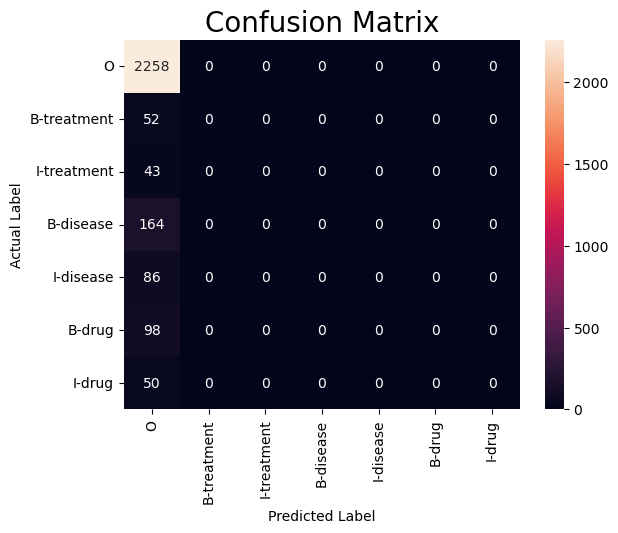

In [16]:
# Compute the confusion matrix
cm = confusion_matrix(tags_english_test, y_prediction)

# Plot the confusion matrix.
sns.heatmap(
    cm,
    annot=True,
    fmt='g',
    xticklabels=['O', 'B-treatment', 'I-treatment', 'B-disease', 'I-disease', 'B-drug', 'I-drug'],
    yticklabels=['O', 'B-treatment', 'I-treatment', 'B-disease', 'I-disease', 'B-drug', 'I-drug']
)
plt.xlabel('Predicted Label', fontsize=10)
plt.ylabel('Actual Label', fontsize=10)
plt.title('Confusion Matrix', fontsize=20)
plt.show()